In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def load_data(filepath):
    h5f = h5py.File(filepath, 'r')
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]
    h5f.close()
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('data/RockAI_299x299_testset50_images.h5')

num_classes = 2

#Pre-process the data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
# datagen = ImageDataGenerator()
datagen.fit(X_train)

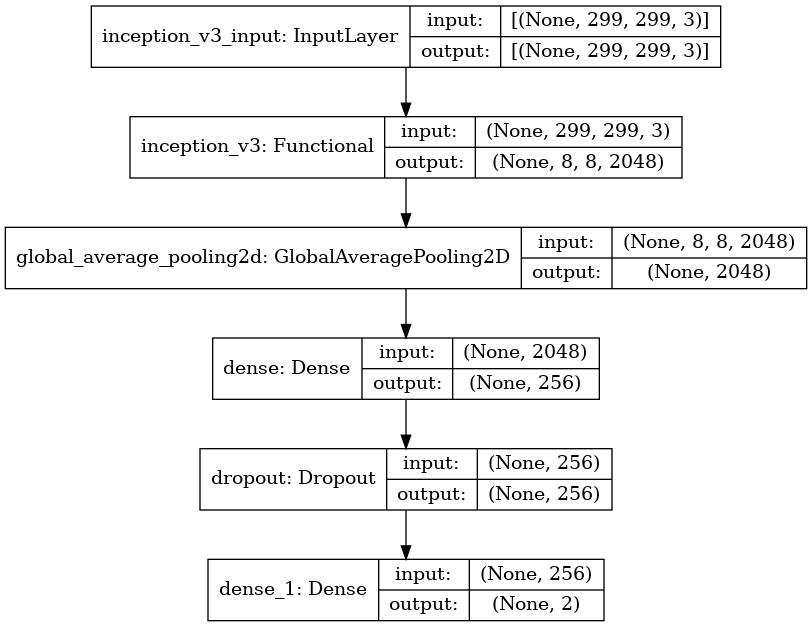

In [5]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inception_model.trainable = False

model = Sequential()
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

tf.keras.utils.plot_model(model, show_shapes=True, to_file='outdir/inception_model.png')

In [6]:
batch_size = 32
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historytemp = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=10)

Epoch 1/10
42/42 [==============================] - 8s 69ms/step - loss: 0.3180 - accuracy: 0.9432
Epoch 2/10
42/42 [==============================] - 2s 51ms/step - loss: 0.1778 - accuracy: 0.9473
Epoch 3/10
42/42 [==============================] - 2s 51ms/step - loss: 0.1142 - accuracy: 0.9636
Epoch 4/10
42/42 [==============================] - 2s 52ms/step - loss: 0.1205 - accuracy: 0.9618
Epoch 5/10
42/42 [==============================] - 2s 52ms/step - loss: 0.1385 - accuracy: 0.9553
Epoch 6/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0971 - accuracy: 0.9625
Epoch 7/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0837 - accuracy: 0.9726
Epoch 8/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0854 - accuracy: 0.9759
Epoch 9/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0819 - accuracy: 0.9776
Epoch 10/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0769 - accuracy: 0.9735


In [7]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 238ms/step - loss: 0.8011 - accuracy: 0.7100


[0.8011012077331543, 0.7099999785423279]

In [8]:
model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.AUC()])

historytemp = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=15)

Epoch 1/15
42/42 [==============================] - 5s 53ms/step - loss: 0.0770 - auc: 0.9946
Epoch 2/15
42/42 [==============================] - 2s 53ms/step - loss: 0.1072 - auc: 0.9913
Epoch 3/15
42/42 [==============================] - 2s 53ms/step - loss: 0.0700 - auc: 0.9971
Epoch 4/15
42/42 [==============================] - 2s 54ms/step - loss: 0.0576 - auc: 0.9979
Epoch 5/15
42/42 [==============================] - 2s 53ms/step - loss: 0.0574 - auc: 0.9980
Epoch 6/15
42/42 [==============================] - 2s 54ms/step - loss: 0.0533 - auc: 0.9977
Epoch 7/15
42/42 [==============================] - 2s 54ms/step - loss: 0.0502 - auc: 0.9985
Epoch 8/15
42/42 [==============================] - 2s 53ms/step - loss: 0.0538 - auc: 0.9981
Epoch 9/15
42/42 [==============================] - 2s 53ms/step - loss: 0.0542 - auc: 0.9982
Epoch 10/15
42/42 [==============================] - 2s 53ms/step - loss: 0.0729 - auc: 0.9962
Epoch 11/15
42/42 [==============================] - 2s 53m

In [9]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 39ms/step - loss: 0.5270 - auc: 0.9117


[0.5270438194274902, 0.9116999506950378]

In [10]:
import sys
sys.path.append('/home/thanhbinh/code')
from butils.base import print_progress
from butils.imutils import load_image_file, resize
import matplotlib.pyplot as plt

In [11]:
image_size = (224, 224)
img = load_image_file('data/test_images/IMG_6961.JPG')
img = resize(img, image_size, keep_aspect=False, crop=False)
print(model.predict(np.array([img])))
plt.imshow(img)

ValueError: in user code:

    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1513 predict_function  *
        return step_function(self, iterator)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1503 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1262 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2734 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3423 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1496 run_step  **
        outputs = model.predict_step(data)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1469 predict_step
        return self(x, training=False)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1011 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/thanhbinh/.conda/envs/rockai/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)
